# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you find **at least two datasets** on the web which are related, and that you visualize these datasets to answer the assignment question. You are free to utilize datasets with any location or domain, the usage of **Ann Arbor sports and athletics** datasets in the example is just a suggestion.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * You must state a question you are seeking to answer with your visualizations.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together as an example! [Example Solution File](./readonly/Assignment4_example.pdf)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def create_df_for_plot():
    # --- Load the trade and CO₂ datasets ---
    trade_df = pd.read_csv("UNexports.csv")
    co2_df = pd.read_csv("consumption-co2-emissions.csv")

    # --- Rename for consistency ---
    trade_df = trade_df.rename(columns={
        "Country or Area": "Country",
        "Trade (USD)": "TradeUSD"
    })
    co2_df = co2_df.rename(columns={
        "Entity": "Country",
        "Annual consumption-based CO₂ emissions": "CO2_consumption"
    })

    # --- Fix country names ---
    trade_df["Country"] = trade_df["Country"].replace({"EU-28": "European Union (28)"})
    co2_df["Country"] = co2_df["Country"].replace({"United States": "USA"})

    # --- Keep only the four countries of interest ---
    selected_countries = ["USA", "China", "Germany", "European Union (28)"]
    trade_df = trade_df[trade_df["Country"].isin(selected_countries)]
    co2_df = co2_df[co2_df["Country"].isin(selected_countries)]

    # --- Convert Year to numeric in both datasets ---
    trade_df["Year"] = pd.to_numeric(trade_df["Year"], errors="coerce")
    co2_df["Year"] = pd.to_numeric(co2_df["Year"], errors="coerce")

    # --- Pivot trade data to get Export and Import in columns ---
    trade_pivot = (
        trade_df.pivot_table(index=["Country", "Year"], 
                             columns="Flow", 
                             values="TradeUSD", 
                             aggfunc="sum", fill_value=0)
        .reset_index()
    )

    # --- Merge with CO₂ data ---
    co2_filtered = co2_df[["Country", "Year", "CO2_consumption"]]
    merged_df = pd.merge(trade_pivot, co2_filtered, on=["Country", "Year"], how="inner")

    # --- Final clean dataframe ---
    final_df = merged_df[["Country", "Year", "Export", "Import", "CO2_consumption"]]
    
    # --- Calculate new columns ---
    final_df['Total_Trade'] = final_df['Export'] + final_df['Import']

    # Calculate CO2 Emissions per $1B Trade. Ensure we don't divide by zero if Total_Trade is 0. We are converting trade to billions for the ratio
    billion = 1_000_000_000
    final_df['CO2_per_Billion_Trade'] = final_df.apply(
        lambda row: (row['CO2_consumption'] / (row['Total_Trade'] / billion)) if row['Total_Trade'] != 0 else 0,
        axis=1)

    # Handle potential inf values if CO2_consumption is high and Total_Trade is very small but not zero
    # For very small trade values, the CO2 per billion trade can become extremely large.
    # It might be wise to cap this value or further investigate such cases if they are prominent.
    # For now, let's replace inf with NaN and then fill NaN with 0 or a reasonable max value if desired for plotting.
    final_df['CO2_per_Billion_Trade'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    final_df['CO2_per_Billion_Trade'].fillna(0, inplace=True) # Or you might choose to fill with the mean/median, or just drop rows
    # --- Display result ---
    return final_df
create_plot_df()

,Country,Year,Export,Import,CO2_consumption,Total_Trade,CO2_per_Billion_Trade
0,China,1992,8.494002e+10,8.058530e+10,2.575791e+09,1.655253e+11,1.556131e+07
1,China,1993,9.174395e+10,1.039589e+11,2.756960e+09,1.957029e+11,1.408748e+07
2,China,1994,1.210063e+11,1.156136e+11,2.749938e+09,2.366199e+11,1.162176e+07
3,China,1995,1.487795e+11,1.320835e+11,2.994028e+09,2.808630e+11,1.066010e+07
4,China,1996,1.510475e+11,1.388327e+11,3.125396e+09,2.898802e+11,1.078168e+07
...,...,...,...,...,...,...,...
113,USA,2018,1.665303e+12,2.611432e+12,5.804062e+09,4.276735e+12,1.357124e+06
114,USA,2019,1.644276e+12,2.567492e+12,5.698775e+09,4.211768e+12,1.353060e+06
115,USA,2020,1.430254e+12,2.405382e+12,5.186863e+09,3.835635e+12,1.352283e+06
116,USA,2021,1.753137e+12,2.932976e+12,5.569804e+09,4.686113e+12,1.188577e+06


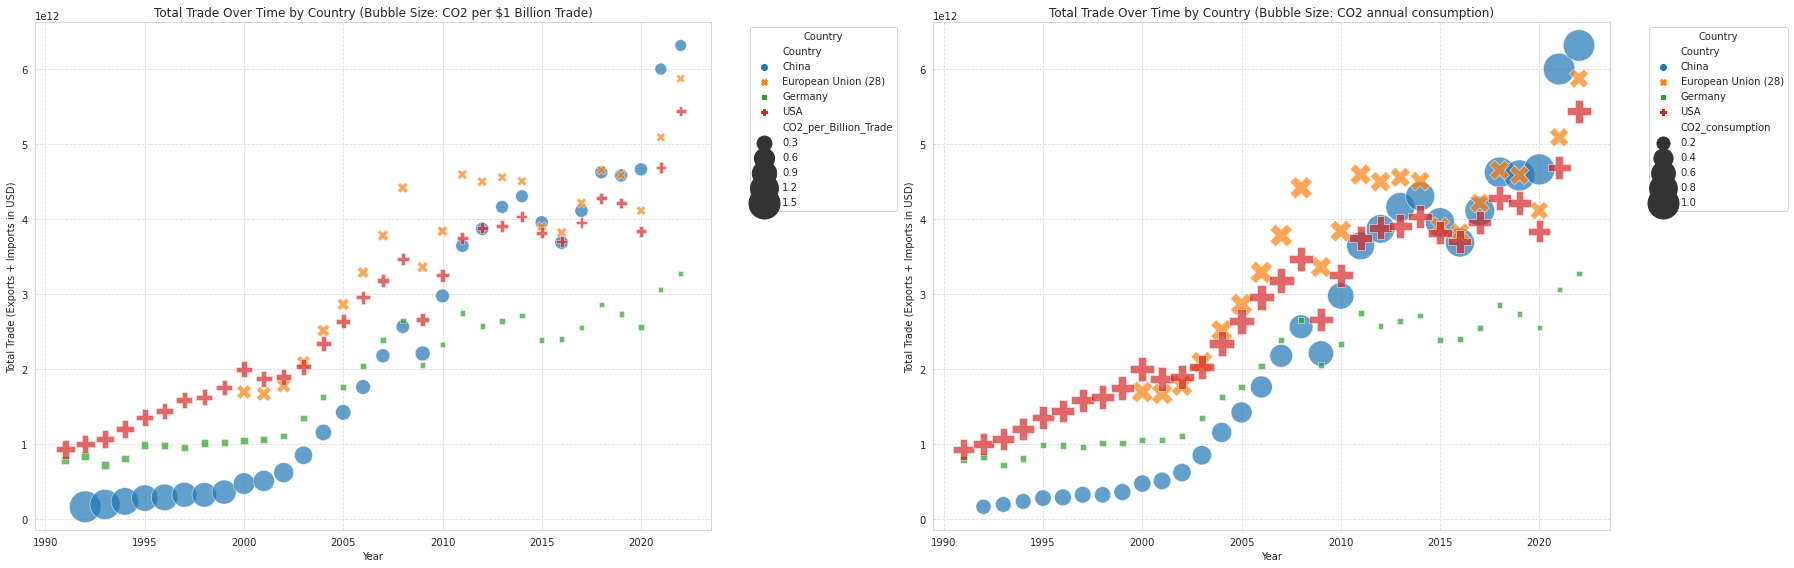

<Figure size 432x288 with 0 Axes>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

def scatterplot():
    
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (10, 6) # Set default figure size

    # -- Dashboard for the plots
    fig, (eff, tot) = plt.subplots(1, 2, figsize=(25, 8)) # Increased figsize for better visibility

    # --- Scatter Plot of CO2 per $1 Billion Trade 'eff' ---
    sns.scatterplot(
        data=create_plot_df(),
        x='Year',
        y='Total_Trade',
        hue='Country',
        style='Country',
        size='CO2_per_Billion_Trade',
        sizes=(50, 1000), # Adjust the size of bubbles as needed
        alpha=0.7,
        ax=eff )

    eff.set_title('Total Trade Over Time by Country (Bubble Size: CO2 per $1 Billion Trade)')
    eff.set_xlabel('Year')
    eff.set_ylabel('Total Trade (Exports + Imports in USD)')
    eff.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    eff.grid(True, linestyle='--', alpha=0.7)

    # --- Scatter Plot of total co2 consumption 'tot' ---
    sns.scatterplot(
        data=create_plot_df(), # Using the same data
        x='Year',
        y='Total_Trade',
        hue='Country',
        style='Country',
        size='CO2_consumption',
        sizes=(50, 1000),
        alpha=0.7,
        ax=tot # Crucially, plot on the 'tot' Axes)

    tot.set_title('Total Trade Over Time by Country (Bubble Size: CO2 annual consumption)') # A slightly different title for clarity
    tot.set_xlabel('Year')
    tot.set_ylabel('Total Trade (Exports + Imports in USD)')
    tot.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    tot.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()
    plt.savefig('trade_co2_scatter_plots.png')
        
scatterplot()

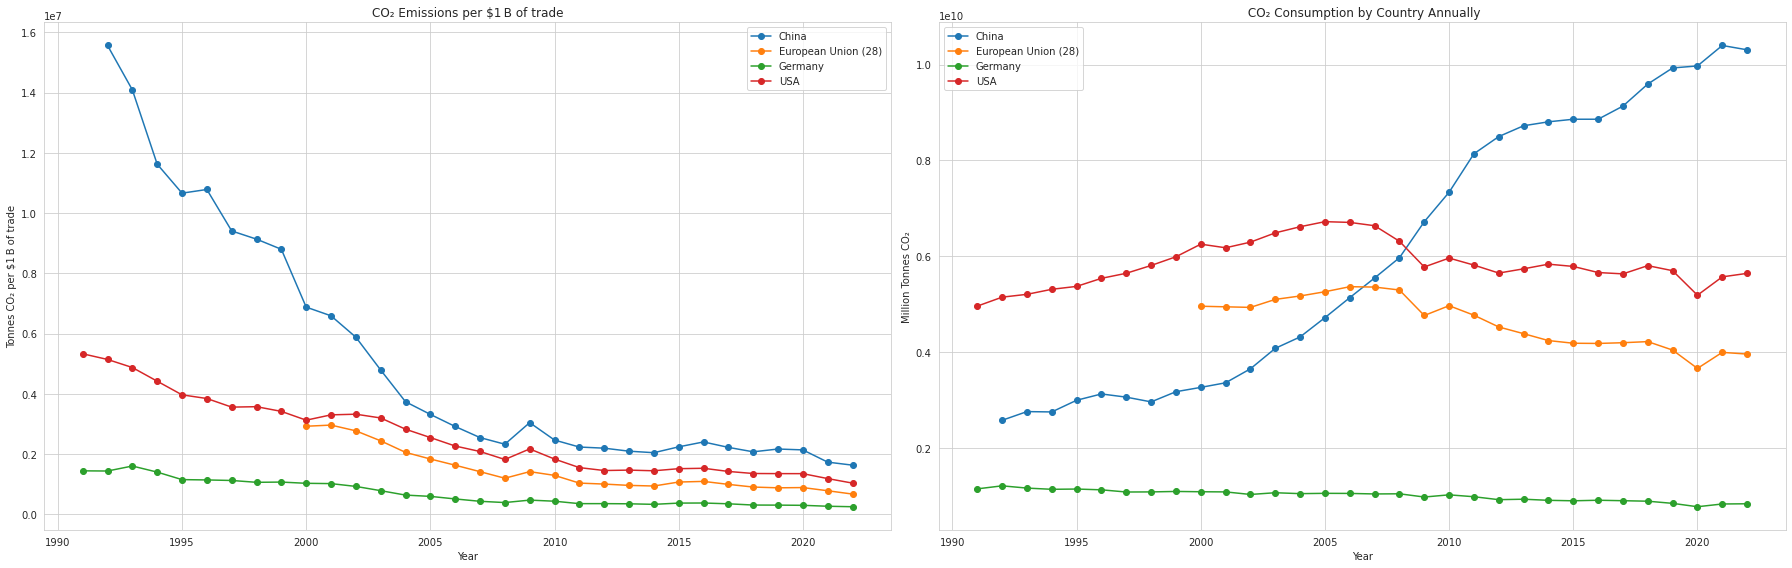

<Figure size 720x432 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def linegraphs():
    
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (10, 6)

    # -- Dashboard for the plots
    fig, (eff_ax, tot_ax) = plt.subplots(1, 2, figsize=(25, 8))  # rename for clarity
    final_df = create_plot_df()

    # ---- Plot 1: efficiency (CO₂ per $1B of trade) ----
    for country in final_df["Country"].unique():
        subset = final_df[final_df["Country"] == country]
        eff_ax.plot(
            subset["Year"],
            subset["CO2_per_Billion_Trade"],
            label=country,
            marker="o")

    eff_ax.set_title("CO₂ Emissions per $1 B of trade")
    eff_ax.set_xlabel("Year")
    eff_ax.set_ylabel("Tonnes CO₂ per $1 B of trade")
    eff_ax.legend()
    eff_ax.grid(True)

    # ---- Plot 2: totals (fill in whatever metric you want) ----
    # Example: total CO₂ emissions
    for country in final_df["Country"].unique():
        subset = final_df[final_df["Country"] == country]
        tot_ax.plot(
            subset["Year"],
            subset["CO2_consumption"],          # change to your actual column
            label=country,
            marker="o")

    tot_ax.set_title(" CO₂ Consumption by Country Annually")
    tot_ax.set_xlabel("Year")
    tot_ax.set_ylabel("Million Tonnes CO₂")
    tot_ax.legend()
    tot_ax.grid(True)

    # ---- Layout & display ----
    fig.tight_layout()   # call this on the Figure, not an Axes
    plt.show()
    plt.savefig('trade_co2_line_graphs.png')
    
linegraphs()


--- Generating Pair Plots (may take a moment) ---


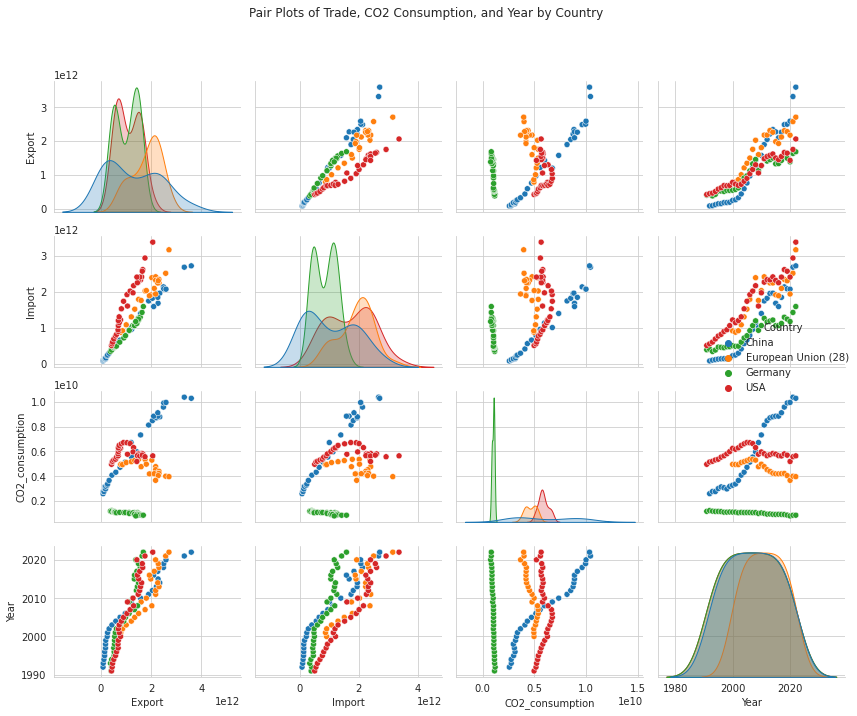

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4. Pair Plots (Advanced, great for overview) ---
# This will generate a grid of scatter plots for each pair of numerical variables,
# and histograms/KDEs for single variable distributions, separated by country.
# This can be computationally intensive for very large datasets.
print("\n--- Generating Pair Plots (may take a moment) ---")
sns.pairplot(final_df, vars=['Export', 'Import', 'CO2_consumption', 'Year'], hue='Country', kind='scatter', diag_kind='kde')
plt.suptitle('Pair Plots of Trade, CO2 Consumption, and Year by Country', y=1.02) # Adjust title position
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()